# Classification with Scikit-Learn
We now consider some examples of supervised learning. We will use the scikit-learn library in Python to do this. Scikit-learn is one of the most popular and easiest to use machine learning libraries out there. Though it is somewhat limited in what it can do (it's not good for deep learning in particular), it's great for everyday machine learning. 

For our example, we will focus on classification using the two main techniques we've covered: logistic regression and KNN, and we'll also quickly mention a couple of the more state of the art techniques. To begin, we load the functions we'll need. When doing machine learning, you almost always need `numpy` (Python's linear algebra library) and `matplotlib` or some other library for plotting. From `sklearn`, we import the classes used for the models we'll be using, a function that automatically splits our dataset into a training set and a test set (to prevent overfitting), and a function that allows us to calculate our training accuracy (percent of correctly classified labels) automatically. We also set a random seed, which is good practice when working with random numbers (as we frequently do in machine learning) to ensure reproducibility of our results.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
np.random.seed(1)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Next, we load a function to generate the simulated data we'll be training on. If you're curious, the function generates 1000 data points using a 2D Gaussian mixture model with five centers per label.

In [3]:
def gen_data(size=1000,centers=5):
    M = [np.random.multivariate_normal(np.array([1,0]),.8*np.eye(2)) for i in range(centers)] +\
        [np.random.multivariate_normal(np.array([0,1]),.8*np.eye(2)) for i in range(centers)]
    
    X = np.zeros((size,2))
    y = np.zeros((size,))
    x1 = []
    x2 = []    
    for j in range(size):
        i = np.random.randint(2*centers)
        m = M[i]
        X[j,:] = np.random.multivariate_normal(np.array(m),.8*np.eye(2)/centers)
        if i<centers:
            y[j] = 0
            x1 += [X[j,:]]
        else:
            y[j] = 1
            x2 += [X[j,:]]
    x1 = np.array(x1).reshape(len(x1),2)
    x2 = np.array(x2).reshape(len(x2),2)
    return X,y,x1,x2

Next, we load a plotting routine. This will allow us to visualize the data and plot decision boundaries to see how well our model is doing.

In [4]:
def plot_model(model,X,y,x1,x2):
    xlim_left = np.min(X[:,0])
    xlim_right = np.max(X[:,0])
    ylim_left = np.min(X[:,1])
    ylim_right = np.max(X[:,1])
    xx, yy = np.mgrid[xlim_left-1:xlim_right+1:.01, ylim_left-1:ylim_right+1:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    f, ax = plt.subplots(figsize=(8, 8))
    
    if model is not None:
        yhat = model.predict(grid).reshape(xx.shape)
        ax.contour(xx, yy, yhat, levels=[.5])
    
    ax.scatter(x1[:,0],x1[:,1],marker='.',c='red',label='y=0')
    ax.scatter(x2[:,0],x2[:,1],marker='.',c='blue',label='y=1')
    
    ax.set(aspect="equal",
           #xlim=(-3, 3), ylim=(-3, 3),
           xlabel="$X_1$", ylabel="$X_2$")
    ax.legend(loc='upper right')

Last, we define a function to generate the scores we'll use to evaluate how well our models are doing.

In [5]:
def get_scores(model,X_train,y_train,X_test,y_test):
    yhat = model.predict(X_train)
    ypred = (yhat>.5)
    conf = metrics.confusion_matrix(y_train,ypred)
    acc = (conf[0,0]+conf[1,1])*1./(conf[0,0]+conf[0,1]+conf[1,0]+conf[1,1])
    print('Training Accuracy: '+str(acc*100.)+'%')

    yhat = model.predict(X_test)
    ypred = (yhat>.5)
    conf = metrics.confusion_matrix(y_test,ypred)
    acc = (conf[0,0]+conf[1,1])*1./(conf[0,0]+conf[0,1]+conf[1,0]+conf[1,1])
    print('Test Accuracy: '+str(acc*100.)+'%')

Now that we've got this out of the way we can proceed with the machine learning. First, we generate the data, saving inputs into a matrix `X` and the outputs into a vector `y`. Each row of `X` is a single example and each column is a feature. This is pretty much the standard format for storing data when doing machine learning, and almost every machine learning algorithm assumes your data is stored this way. We also store two more arrays `x1` and `x2` that separates the input data by label, just for plotting purposes.

Next, we separate the data into a training set and a test set using the `train_test_split` function. Remember this is to prevent overfitting. We want to train only on the training data `X_train` and `y_train`, and test our model only on the test data `X_test` and `y_test`. The `test_size=0.2` term means that we want 80% of our total data to go into the training set, and the remaining 20% into the test set. This is a fairly standard way to split your data. You always want most of your data going into your training set because models tend to train better when given more data. But you need to have enough test data to reliably evaluate your model, so you can't skimp there either.

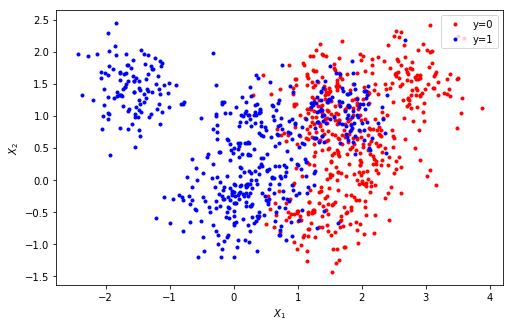

In [8]:
X,y,x1,x2 = gen_data()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
plot_model(None,X,y,x1,x2)

Since our data is set up for training we can now get to the modeling. First we use logistic regression. Note the Scikit-Learn APIs are object-oriented, so we first have to instantiate the model class, and then call the fit method for the actual training. After the fit method obtains the optimal weights, we call the predict method on both our training and test sets to get our optimal predictions $\hat y$, and then evaluate how well the model is doing. Finally, we use the plot function we defined above to show our classification. What do you notice about the decision boundary in particular?

Training Accuracy: 81.0%
Test Accuracy: 83.5%


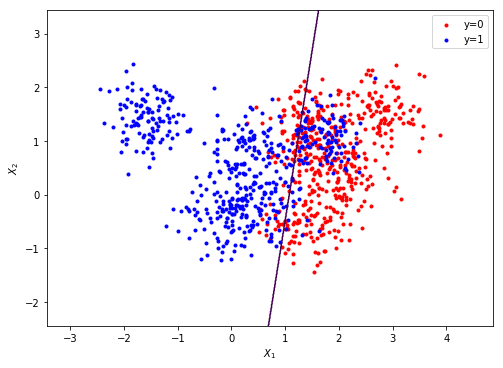

In [9]:
model = LogisticRegression()
model.fit(X_train,y_train)

get_scores(model,X_train,y_train,X_test,y_test)
plot_model(model,X,y,x1,x2)

Next, let's try using a KNN model instead. Thanks to Scikit-Learn's simple API, the code is almost exactly the same as before, with the exception of the class we call. The `n_neighbors` parameter is the choice of $k$. What do you notice about the decision boundary now? Also, play around with different values of $k$ and see what happens to your training accuracy, test accuracy, and decision boundary.

Training Accuracy: 83.625%
Test Accuracy: 84.0%


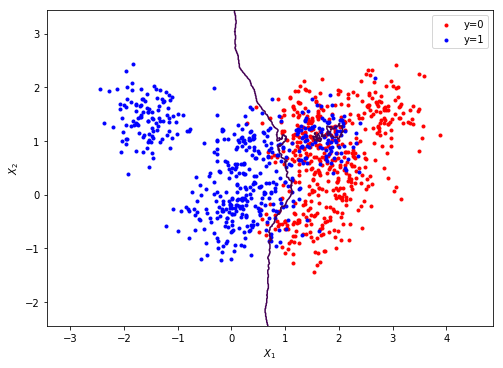

In [13]:
model = KNeighborsClassifier(n_neighbors=50)
model.fit(X_train,y_train)

get_scores(model,X_train,y_train,X_test,y_test)
plot_model(model,X,y,x1,x2)

We finish up by looking at a couple of the more state of the art classification algorithms: random forests and gradient boosting trees.

_Random forests_ works by creating a whole bunch of decision trees, where each decision tree tries to find the best ways to split the data, and then averages the results together to make a prediction. This averaging is called _ensembling_ in machine learning. RFs are very popular algorithms to use when dealing with structured data in particular. They're also very interpretable, which is becoming more and more important in ML (if you're curious, look up the `tree-interpreter` library).

Training Accuracy: 88.75%
Test Accuracy: 84.0%


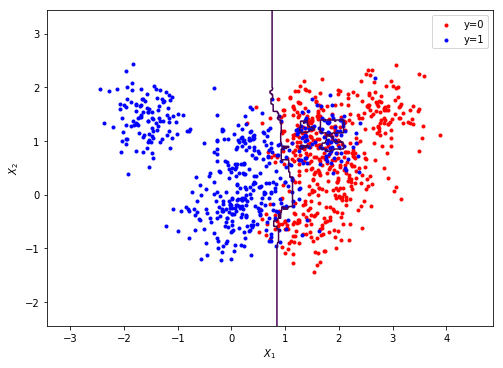

In [14]:
model = RandomForestClassifier(n_estimators=100,min_samples_leaf=13)
model.fit(X_train,y_train)

get_scores(model,X_train,y_train,X_test,y_test)
plot_model(model,X,y,x1,x2)

Last, we look at _gradient boosting trees_ using the very powerful XGBoost library. This is about as state of the art as ML gets when not dealing with deep learning stuff. GBTs also work by creating decision trees, but instead of ensembling the trees it does _boosting_ on them. Boosting means that it takes the output of one tree, calculates its residual error $y-\hat y$, then feeds that into the next tree and uses that tree to try to predict that error. It does this over and over again.

Note: If you don't have the XGBoost library installed you can just ignore this section, as it's often a pain to get the library installed and working correctly. If you have the time though I highly recommend getting the library installed and working, as it's a very useful library in practice.

Notice that the API for XGBoost is very similar to the one for Scikit-Learn.

Training Accuracy: 87.625%
Test Accuracy: 84.5%


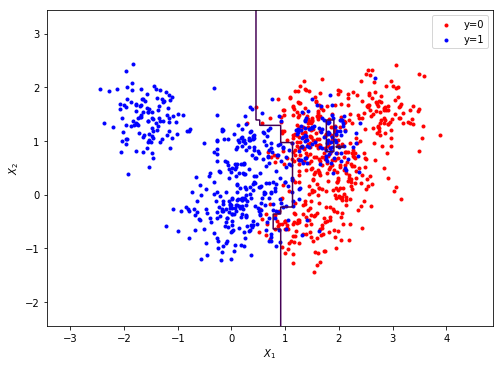

In [15]:
# had to do this because the kernel kept crashing...
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# here's the important part
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=55)
model.fit(X_train,y_train)

get_scores(model,X_train,y_train,X_test,y_test)
plot_model(model,X,y,x1,x2)